# Goal: given bbox and time construct ATL03 database (footprint + timestamp)

based on https://git.earthdata.nasa.gov/projects/LPDUR/repos/cmr-api---hls-bulk-query/browse

Steps:

1. do it serial
2. use an async function

In [1]:
import requests
import math
import aiohttp
import asyncio
import time

import pandas as pd
import shapely
import geopandas as gpd

In [2]:
CMR_OPS = 'https://cmr.earthdata.nasa.gov/search' # CMR API Endpoint
url = f'{CMR_OPS}/{"granules"}'
print(url)

https://cmr.earthdata.nasa.gov/search/granules


## Smallish testcase

In [18]:
# https://github.com/Element84/cmr-stac-api-proxy/issues/30
collections = ['C2120512202-NSIDC_ECS'] # Version 5
collections = ['C2559919423-NSIDC_ECS'] # Version 6

datetime_range = '2021-10-17T00:00:00Z,2021-10-19T23:59:59Z'
bbox = '-170,60,-140,70' # most of alaska
page_size = 2000

In [19]:
%%time

# All time: 5.44s, 4039 granules
# 2021-10-17 to 19: Wall time: 1.8 s, 9 granules, 300-640 ms today, seems quite variable...

response = requests.get(url, 
                        params={
                            'concept_id': collections,
                            'temporal': datetime_range,
                            'bounding_box': bbox,
                            'page_size': page_size,
                            },
                        headers={
                            'Accept': 'application/json'
                            }
                       )
print(response.status_code)

200
CPU times: user 15.5 ms, sys: 4.66 ms, total: 20.1 ms
Wall time: 571 ms


In [20]:
print(response.headers['CMR-Hits']) # Resulting quantity of granules/items.

8


In [21]:
%%time
# Actually get JSON per granule (1st 2000 hits)
granules = response.json()['feed']['entry']

CPU times: user 761 µs, sys: 0 ns, total: 761 µs
Wall time: 767 µs


In [22]:
# Just create a dataframe with the basics
keys = ['producer_granule_id', 'time_start', 'time_end', 'polygons'] #, ?link {key: old_dict[key] for key in your_keys}

# nested list comprehension to filter dictionaries
df = pd.DataFrame([{key: x[key] for key in keys} for x in granules])
df.head()

,producer_granule_id,time_start,time_end,polygons
0,ATL03_20211017095408_03811305_006_01.h5,2021-10-17T09:54:08.705Z,2021-10-17T09:59:33.831Z,[[80.02712 -150.26295 80.05118 -150.89772 79.4...
1,ATL03_20211017204335_03881303_006_01.h5,2021-10-17T20:43:36.058Z,2021-10-17T20:49:01.491Z,[[80.05093 -157.16028 80.02701 -157.79545 79.6...
2,ATL03_20211018092829_03961305_006_01.h5,2021-10-18T09:28:29.226Z,2021-10-18T09:33:54.653Z,[[80.02743 -144.55886 80.05128 -145.1973 79.47...
3,ATL03_20211018201756_04031303_006_01.h5,2021-10-18T20:17:56.827Z,2021-10-18T20:23:22.267Z,[[80.05083 -151.44547 80.02695 -152.08076 79.6...
4,ATL03_20211018215214_04041303_006_01.h5,2021-10-18T21:52:14.265Z,2021-10-18T21:57:39.707Z,[[80.0508 -175.07255 80.0269 -175.7078 79.5973...


In [23]:
df['time_start'] = pd.to_datetime(df.time_start).dt.tz_localize(None)
df['time_end'] = pd.to_datetime(df.time_end).dt.tz_localize(None)
df['datetime'] = df.time_start + (df.time_end - df.time_start)/2
df.head()

,producer_granule_id,time_start,time_end,polygons,datetime
0,ATL03_20211017095408_03811305_006_01.h5,2021-10-17 09:54:08.705,2021-10-17 09:59:33.831,[[80.02712 -150.26295 80.05118 -150.89772 79.4...,2021-10-17 09:56:51.268000
1,ATL03_20211017204335_03881303_006_01.h5,2021-10-17 20:43:36.058,2021-10-17 20:49:01.491,[[80.05093 -157.16028 80.02701 -157.79545 79.6...,2021-10-17 20:46:18.774500
2,ATL03_20211018092829_03961305_006_01.h5,2021-10-18 09:28:29.226,2021-10-18 09:33:54.653,[[80.02743 -144.55886 80.05128 -145.1973 79.47...,2021-10-18 09:31:11.939500
3,ATL03_20211018201756_04031303_006_01.h5,2021-10-18 20:17:56.827,2021-10-18 20:23:22.267,[[80.05083 -151.44547 80.02695 -152.08076 79.6...,2021-10-18 20:20:39.547000
4,ATL03_20211018215214_04041303_006_01.h5,2021-10-18 21:52:14.265,2021-10-18 21:57:39.707,[[80.0508 -175.07255 80.0269 -175.7078 79.5973...,2021-10-18 21:54:56.986000


In [24]:
def polygons2shapely(polygons):
    ''' convert CMR string to shapely polygon for geopandas '''
    coordlist = polygons[0][0].split() #list of lists (assume just one though)
    lats = [float(x) for x in coordlist[::2]]
    lons = [float(x) for x in coordlist[1::2]]
    poly = shapely.geometry.Polygon(zip(lons,lats))
    # Proper orientation to denote exterior boundary (poly.exterior.is_ccw)
    poly = shapely.geometry.polygon.orient(poly)
    return poly

In [25]:
poly = polygons2shapely(df.polygons.values[0])

In [26]:
poly.exterior.is_ccw

True

In [27]:
df['geometry'] = df.polygons.apply(lambda x: polygons2shapely(x))

In [28]:
gf = gpd.GeoDataFrame(df, crs='EPSG:4326')
gf.head()

,producer_granule_id,time_start,time_end,polygons,datetime,geometry
0,ATL03_20211017095408_03811305_006_01.h5,2021-10-17 09:54:08.705,2021-10-17 09:59:33.831,[[80.02712 -150.26295 80.05118 -150.89772 79.4...,2021-10-17 09:56:51.268000,"POLYGON ((-150.26295 80.02712, -150.89772 80.0..."
1,ATL03_20211017204335_03881303_006_01.h5,2021-10-17 20:43:36.058,2021-10-17 20:49:01.491,[[80.05093 -157.16028 80.02701 -157.79545 79.6...,2021-10-17 20:46:18.774500,"POLYGON ((-157.16028 80.05093, -157.79545 80.0..."
2,ATL03_20211018092829_03961305_006_01.h5,2021-10-18 09:28:29.226,2021-10-18 09:33:54.653,[[80.02743 -144.55886 80.05128 -145.1973 79.47...,2021-10-18 09:31:11.939500,"POLYGON ((-144.55886 80.02743, -145.19730 80.0..."
3,ATL03_20211018201756_04031303_006_01.h5,2021-10-18 20:17:56.827,2021-10-18 20:23:22.267,[[80.05083 -151.44547 80.02695 -152.08076 79.6...,2021-10-18 20:20:39.547000,"POLYGON ((-151.44547 80.05083, -152.08076 80.0..."
4,ATL03_20211018215214_04041303_006_01.h5,2021-10-18 21:52:14.265,2021-10-18 21:57:39.707,[[80.0508 -175.07255 80.0269 -175.7078 79.5973...,2021-10-18 21:54:56.986000,"POLYGON ((-175.07255 80.05080, -175.70780 80.0..."


<AxesSubplot: >

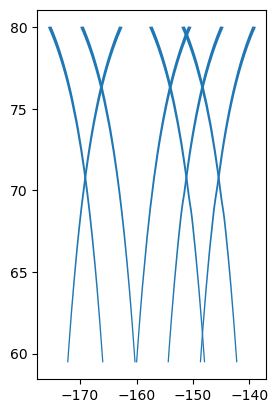

In [29]:
gf.plot()

## Most of alaska 

In [32]:
params={
    #'concept_id': ['C2120512202-NSIDC_ECS'], # Version 5
    'concept_id': ['C2559919423-NSIDC_ECS'], # Version 6
    #'temporal': '2021-10-17T00:00:00Z,2021-10-19T23:59:59Z',
    'bounding_box': '-170,60,-140,70',
    'page_size': 2000,
    }

In [33]:
def get_page_total(params):
    hits = requests.get(url, 
                        params=params,
                        headers={
                            'Accept': 'application/json'
                            }
                       ).headers['CMR-Hits']
    
    print(f'Granules= {hits}') 
    pages = math.ceil(int(hits)/params['page_size'])
    print(f'Pages= {pages}')
    
    return pages

In [34]:
%%time
get_page_total(params)

Granules= 4490
Pages= 3
CPU times: user 79.7 ms, sys: 11.3 ms, total: 91 ms
Wall time: 2.68 s


3

In [35]:
def get_cmr_granules(params):
    response = requests.get("https://cmr.earthdata.nasa.gov/search/granules", 
                        params=params,
                        headers={
                            'Accept': 'application/json'
                            }
                       )
    
    
    granules = response.json()['feed']['entry']
    keys = ['producer_granule_id', 'time_start', 'time_end', 'polygons']
    df = pd.DataFrame([{key: x[key] for key in keys} for x in granules])
    return df

In [36]:
%%time

df = get_cmr_granules(params)
df.head(3)

CPU times: user 235 ms, sys: 61 ms, total: 296 ms
Wall time: 3.42 s


,producer_granule_id,time_start,time_end,polygons
0,ATL03_20181014015337_02360103_006_02.h5,2018-10-14T01:53:36.912Z,2018-10-14T01:59:02.315Z,[[80.05247 -166.98121 80.02874 -167.61386 79.5...
1,ATL03_20181014130413_02430105_006_02.h5,2018-10-14T13:04:12.567Z,2018-10-14T13:09:37.946Z,[[80.02773 -130.816 80.05141 -131.44724 79.599...
2,ATL03_20181014143830_02440105_006_02.h5,2018-10-14T14:38:29.879Z,2018-10-14T14:43:55.296Z,[[80.02762 -154.42548 80.05132 -155.0567 79.58...


## ASYNC

In [37]:
params={
    #'concept_id': ['C2120512202-NSIDC_ECS'],
    'concept_id': ['C2559919423-NSIDC_ECS'], # Version 6
    #'temporal': '2021-10-17T00:00:00Z,2021-10-19T23:59:59Z',
    'bounding_box': '-170,60,-140,70',
    'page_size': 2000,
    }

In [38]:
def get_cmr_pages_urls(params): 
    response = requests.get('https://cmr.earthdata.nasa.gov/search/granules',
                       params=params,
                       headers={
                           'Accept': 'application/json'
                       }
                      )
    hits = int(response.headers['CMR-Hits'])
    n_pages = math.ceil(hits/page_size)
    cmr_pages_urls = [f'{response.url}&page_num={x}'.replace('granules?', 'granules.json?') for x in list(range(1,n_pages+1))]
    return cmr_pages_urls

In [39]:
urls = get_cmr_pages_urls(params)
urls

['https://cmr.earthdata.nasa.gov/search/granules.json?concept_id=C2559919423-NSIDC_ECS&bounding_box=-170%2C60%2C-140%2C70&page_size=2000&page_num=1',
 'https://cmr.earthdata.nasa.gov/search/granules.json?concept_id=C2559919423-NSIDC_ECS&bounding_box=-170%2C60%2C-140%2C70&page_size=2000&page_num=2',
 'https://cmr.earthdata.nasa.gov/search/granules.json?concept_id=C2559919423-NSIDC_ECS&bounding_box=-170%2C60%2C-140%2C70&page_size=2000&page_num=3']

In [40]:
results = []

In [41]:
def get_tasks(session):
    tasks = []
    for l in urls:
        tasks.append(session.get(l))
    return tasks

In [42]:
async def get_url():
    async with aiohttp.ClientSession() as session:
        tasks = get_tasks(session)
        responses = await asyncio.gather(*tasks)
        for response in responses:
            res = await response.json()
            #print(res)
            granules = res['feed']['entry']
            results.extend([{key: x[key] for key in keys} for x in granules])

In [43]:
start = time.time() 

await get_url()

end = time.time()

total_time = end - start
total_time

24.869367361068726

In [44]:
len(results)

4490

In [45]:
%%time 

df = pd.DataFrame(results)
df.head(3)

CPU times: user 5.1 ms, sys: 307 µs, total: 5.4 ms
Wall time: 5.21 ms


,producer_granule_id,time_start,time_end,polygons
0,ATL03_20181014015337_02360103_006_02.h5,2018-10-14T01:53:36.912Z,2018-10-14T01:59:02.315Z,[[80.05247 -166.98121 80.02874 -167.61386 79.5...
1,ATL03_20181014130413_02430105_006_02.h5,2018-10-14T13:04:12.567Z,2018-10-14T13:09:37.946Z,[[80.02773 -130.816 80.05141 -131.44724 79.599...
2,ATL03_20181014143830_02440105_006_02.h5,2018-10-14T14:38:29.879Z,2018-10-14T14:43:55.296Z,[[80.02762 -154.42548 80.05132 -155.0567 79.58...


In [46]:
#%%time 
# non-blocking for some reason so %%time doesn work...

start = time.time() 

# Add midpoint time, coerce to shapely geometry.
# NOTE: make this faster? 
df['time_start'] = pd.to_datetime(df.time_start).dt.tz_localize(None)
df['time_end'] = pd.to_datetime(df.time_end).dt.tz_localize(None)
df['datetime'] = df.time_start + (df.time_end - df.time_start)/2
df['geometry'] = df.polygons.apply(lambda x: polygons2shapely(x))
gf = gpd.GeoDataFrame(df.drop(columns='polygons'), crs='EPSG:4326')


end = time.time()
total_time = end - start
total_time

0.7252495288848877

In [47]:
gf.head()

,producer_granule_id,time_start,time_end,datetime,geometry
0,ATL03_20181014015337_02360103_006_02.h5,2018-10-14 01:53:36.912,2018-10-14 01:59:02.315,2018-10-14 01:56:19.613500,"POLYGON ((-166.98121 80.05247, -167.61386 80.0..."
1,ATL03_20181014130413_02430105_006_02.h5,2018-10-14 13:04:12.567,2018-10-14 13:09:37.946,2018-10-14 13:06:55.256500,"POLYGON ((-130.81600 80.02773, -131.44724 80.0..."
2,ATL03_20181014143830_02440105_006_02.h5,2018-10-14 14:38:29.879,2018-10-14 14:43:55.296,2018-10-14 14:41:12.587500,"POLYGON ((-154.42548 80.02762, -155.05670 80.0..."
3,ATL03_20181015012758_02510103_006_02.h5,2018-10-15 01:27:57.020,2018-10-15 01:33:22.415,2018-10-15 01:30:39.717500,"POLYGON ((-161.27172 80.05242, -161.90395 80.0..."
4,ATL03_20181015141251_02590105_006_02.h5,2018-10-15 14:12:49.940,2018-10-15 14:18:15.349,2018-10-15 14:15:32.644500,"POLYGON ((-148.71786 80.02766, -149.34874 80.0..."


In [48]:
len(gf)

4490

In [53]:
gf.to_file('IS2_Alaska.geojson', driver='GeoJSON')

In [54]:
gf.to_file('IS2_Alaska.gpkg', driver='GPKG')

In [55]:
gf.to_parquet('IS2_Alaska.parquet', version='2.6')

In [56]:
!ls -lh IS2*

-rw-r--r-- 1 jovyan jovyan 6.8M Jul 19 14:43 IS2_Alaska.geojson
-rw-r--r-- 1 jovyan jovyan 4.8M Jul 19 14:43 IS2_Alaska.gpkg
-rw-r--r-- 1 jovyan jovyan 3.5M Jul 19 14:43 IS2_Alaska.parquet


In [57]:
test = gpd.read_file('IS2_Alaska.geojson')

In [58]:
test.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 4490 entries, 0 to 4489
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   producer_granule_id  4490 non-null   object        
 1   time_start           4490 non-null   datetime64[ns]
 2   time_end             4490 non-null   datetime64[ns]
 3   datetime             4490 non-null   datetime64[ns]
 4   geometry             4490 non-null   geometry      
dtypes: datetime64[ns](3), geometry(1), object(1)
memory usage: 175.5+ KB


In [59]:
gf = gpd.read_file('https://github.com/scottyhq/IS2I/raw/main/IS2_Alaska.geojson')
gf.head(3)

,producer_granule_id,time_start,time_end,datetime,geometry
0,ATL03_20181014015337_02360103_005_01.h5,2018-10-14 01:53:36.912,2018-10-14 01:59:02.315,2018-10-14 01:56:19.614,"POLYGON ((-158.02215 57.70234, -157.41701 57.7..."
1,ATL03_20181014130413_02430105_005_01.h5,2018-10-14 13:04:12.567,2018-10-14 13:09:37.946,2018-10-14 13:06:55.257,"POLYGON ((-125.59580 82.61181, -128.03395 82.7..."
2,ATL03_20181014143830_02440105_005_01.h5,2018-10-14 14:38:29.879,2018-10-14 14:43:55.296,2018-10-14 14:41:12.588,"POLYGON ((-149.21453 82.61181, -151.65268 82.7..."
